In [22]:
from __future__ import annotations
from langchain_core.output_parsers import JsonOutputParser , PydanticOutputParser
import operator
from google import genai
from google.genai import types
import os
from pathlib import Path
from datetime import date, timedelta
from typing import TypedDict, List, Optional, Literal, Annotated
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [23]:
# -----------------------------
# 1) Schemas
# -----------------------------
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=6,
        description="3–6 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(..., description="Target word count for this section (120–550).")

    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False


class Plan(BaseModel):
    blog_title: str
    audience: str
    tone: str
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]


class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None  # keep if Tavily provides; DO NOT rely on it
    snippet: Optional[str] = None
    source: Optional[str] = None


class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    queries: List[str] = Field(default_factory=list)


class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)
    

class ImageSpec(BaseModel):
    placeholder: str = Field(..., description="e.g. [[IMAGE_1]]")
    filename: str = Field(..., description="Save under images/, e.g. qkv_flow.png")
    alt: str
    caption: str
    prompt: str = Field(..., description="Prompt to send to the image model.")
    size: Literal["1024x1024", "1024x1536", "1536x1024"] = "1024x1024"
    quality: Literal["low", "medium", "high"] = "medium"


class GlobalImagePlan(BaseModel):
    md_with_placeholders: str
    images: List[ImageSpec] = Field(default_factory=list)

In [24]:
class State(TypedDict):
    topic: str

    # routing / research
    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]

    # workers
    sections: Annotated[List[tuple[int, str]], operator.add]  # (task_id, section_md)

    # reducer/image
    merged_md: str
    md_with_placeholders: str
    image_specs: List[dict]
   
    final: str

In [25]:
structured_llm = ChatOllama(
    model="deepseek-r1:latest",
    format="json",
    temperature=0
)

# LLM for content generation (without JSON mode)
content_llm = ChatOllama(
    model="llama3.2:latest",
    temperature=0.7
)
from langchain_google_genai import ChatGoogleGenerativeAI
image_gen = ChatGoogleGenerativeAI(model = "")

### router , research node ,  orchestrator node , worker  node . 

In [26]:
# -----------------------------
# 3) Router (decide upfront)
# -----------------------------
ROUTER_SYSTEM = """You are a routing module for a technical blog planner.

Decide whether web research is needed BEFORE planning.

Modes:
- closed_book (needs_research=false):
  Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
- hybrid (needs_research=true):
  Mostly evergreen but needs up-to-date examples/tools/models to be useful.
- open_book (needs_research=true):
  Mostly volatile: weekly roundups, "this week", "latest", rankings, pricing, policy/regulation.

If needs_research=true:
- Output 3–10 high-signal queries.
- Queries should be scoped and specific (avoid generic queries like just "AI" or "LLM").
- If user asked for "last week/this week/latest", reflect that constraint IN THE QUERIES.
"""
def router_node(state: State) -> dict:

    parser = PydanticOutputParser(pydantic_object=RouterDecision)

    prompt = ChatPromptTemplate.from_messages([
        ("system", ROUTER_SYSTEM + "\n{format_instructions}"),
        ("human", "{topic}")
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser     # ✅ plain ChatOllama

    decision = chain.invoke({"topic": state["topic"]})

    return {
        "needs_research": decision.needs_research,
        "mode": decision.mode,
        "queries": decision.queries,
    }

def route_next(state: State) -> str:
    return "research" if state["needs_research"] else "orchestrator"

# -----------------------------
# 4) Research (Tavily) 
# -----------------------------
from dotenv import load_dotenv
load_dotenv()
def _tavily_search(query: str, max_results: int = 5) -> List[dict]:
    
    tool = TavilySearchResults(max_results=max_results)
    results = tool.invoke({"query": query})

    normalized: List[dict] = []
    for r in results or []:
        normalized.append(
            {
                "title": r.get("title") or "",
                "url": r.get("url") or "",
                "snippet": r.get("content") or r.get("snippet") or "",
                "published_at": r.get("published_date") or r.get("published_at"),
                "source": r.get("source"),
            }
        )
    return normalized


RESEARCH_SYSTEM = """You are a research synthesizer for technical writing.

Given raw web search results, produce a deduplicated list of EvidenceItem objects.

Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
  If missing or unclear, set published_at=null. Do NOT guess.
- Keep snippets short.
- Deduplicate by URL.
"""
from langchain_core.output_parsers import PydanticOutputParser

def research_node(state: State) -> dict:

    queries = state.get("queries", []) or []
    max_results = 6

    raw_results: List[dict] = []
    for q in queries:
        raw_results.extend(_tavily_search(q, max_results=max_results))

    if not raw_results:
        return {"evidence": []}

    parser = PydanticOutputParser(pydantic_object=EvidencePack)

    prompt = ChatPromptTemplate.from_messages([
        ("system", RESEARCH_SYSTEM + "\n{format_instructions}"),
        ("human", "Raw Results:\n{raw_results}")
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser     #  plain ChatOllama

    pack = chain.invoke({"raw_results": raw_results})

    # Deduplicate by URL
    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e

    return {"evidence": list(dedup.values())}
# -----------------------------
# 5) Orchestrator (Plan)
# -----------------------------
ORCH_SYSTEM = """You are a senior technical writer and developer advocate.
Your job is to produce a highly actionable outline for a technical blog post.

Hard requirements:
- Create 3-5 sections (tasks) suitable for the topic and audience.
- Each task must include:
  1) goal (1 sentence)
  2) 3–6 bullets that are concrete, specific, and non-overlapping
  3) target word count (120–550)

Quality bar:
- Assume the reader is a developer; use correct terminology.
- Bullets must be actionable: build/compare/measure/verify/debug.
- Ensure the overall plan includes at least 2 of these somewhere:
  * minimal code sketch / MWE (set requires_code=True for that section)
  * edge cases / failure modes
  * performance/cost considerations
  * security/privacy considerations (if relevant)
  * debugging/observability tips

Grounding rules:
- Mode closed_book: keep it evergreen; do not depend on evidence.
- Mode hybrid:
  - Use evidence for up-to-date examples (models/tools/releases) in bullets.
  - Mark sections using fresh info as requires_research=True and requires_citations=True.
- Mode open_book:
  - Set blog_kind = "news_roundup".
  - Every section is about summarizing events + implications.
  - DO NOT include tutorial/how-to sections unless user explicitly asked for that.
  - If evidence is empty or insufficient, create a plan that transparently says "insufficient sources"
    and includes only what can be supported.

Output must strictly match the Plan schema.
"""
def orchestrator_node(state: State) -> dict:

    evidence = state.get("evidence", [])
    mode = state.get("mode", "closed_book")

    parser = PydanticOutputParser(pydantic_object=Plan)

    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "Create a blog plan with 5–7 sections.\n{format_instructions}"
        ),
        (
            "human",
            "Topic: {topic}\n"
            "Mode: {mode}\n\n"
            "Evidence (ONLY use for fresh claims; may be empty):\n"
            "{evidence}"
        )
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser   # ✅ plain ChatOllama

    plan = chain.invoke({
        "topic": state["topic"],
        "mode": mode,
        "evidence": [e.model_dump() for e in evidence][:16],
    })

    return {"plan": plan}

# -----------------------------
# 6) Fanout
# -----------------------------
def fanout(state: State):
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]
    
# -----------------------------
# 7) Worker (write one section)
# -----------------------------
WORKER_SYSTEM = """You are a senior technical writer and developer advocate.
Write ONE section of a technical blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard:
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book:
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true:
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""

def worker_node(payload: dict) -> dict:
    
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )

    section_md = content_llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()

    return {"sections": [(task.id, section_md)]}

### image gen  Workflow 

In [27]:
def merge_content(state: State) -> dict:

    plan = state["plan"]

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    merged_md = f"# {plan.blog_title}\n\n{body}\n"
    return {"merged_md": merged_md}

DECIDE_IMAGES_SYSTEM = """You are an expert technical editor.
Decide if images/diagrams are needed for THIS blog.

Rules:
- Max 2 images total.
- Each image must materially improve understanding (diagram/flow/table-like visual).
- Insert placeholders exactly: [[IMAGE_1]], [[IMAGE_2]].
- If no images needed: md_with_placeholders must equal input and images=[].
- Avoid decorative images; prefer technical diagrams with short labels.
Return strictly GlobalImagePlan.
"""

def decide_images(state: State) -> dict:
    
    parser = PydanticOutputParser(pydantic_object=GlobalImagePlan)    
    merged_md = state["merged_md"]
    plan = state["plan"]
    assert plan is not None
    prompt = ChatPromptTemplate.from_messages([
        ("system", DECIDE_IMAGES_SYSTEM + "\n{format_instructions}"),
        ("human", "Topic: {topic}\n"
                    "blog kind: {blog_kind}\n\n"
                     "Insert placeholders + propose image prompts.\n\n"
                    "{merged_md}")
    ])
    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )
    chain = prompt | structured_llm | parser
    image_plan = chain.invoke({
        "topic": state["topic"],
        "blog_kind": plan.blog_kind,
        "merged_md": merged_md
    })


    return {
        "md_with_placeholders": image_plan.md_with_placeholders,
        "image_specs": [img.model_dump() for img in image_plan.images],
    }

In [20]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

google_llm = ChatGoogleGenerativeAI(model ="gemini-2.5-flash")

In [ ]:
MARKDOWN_IMAGE_PROMPT = """
You are an AI system designer agent.

Your task is to generate a clean ASCII diagram of the given system.

Rules:
- Use ONLY text characters like:
  |  _  -  =  +  >  <
- No markdown tables
- No emojis
- No explanation
- Only the diagram

Style:
- Rectangular boxes
- Clear arrows between components
- Vertically aligned flow
- One main pipeline
"""

def generate_and_place_images(state: State) -> dict:
    """Generate ASCII markdown diagrams and place them in markdown"""

    plan = state["plan"]
    assert plan is not None

    md = state.get("md_with_placeholders") or state["merged_md"]
    image_specs = state.get("image_specs", []) or []

    if not image_specs:
        out_file = f"{plan.blog_title}.md"
        Path(out_file).write_text(md, encoding="utf-8")
        return {"final": md}

    for spec in image_specs:
        placeholder = spec["placeholder"]

        try:
            resp = google_llm.invoke([
                SystemMessage(content=MARKDOWN_IMAGE_PROMPT),
                HumanMessage(content=spec["prompt"])
            ])

            ascii_diagram = resp.content.strip()

            md = md.replace(placeholder, ascii_diagram)

        except Exception as e:
            prompt_block = (
                f"> **[IMAGE GENERATION FAILED]** {spec.get('caption','')}\n>\n"
                f"> **Alt:** {spec.get('alt','')}\n>\n"
                f"> **Prompt:** {spec.get('prompt','')}\n>\n"
                f"> **Error:** {e}\n"
            )
            md = md.replace(placeholder, prompt_block)
            print(f"md image gen failed: {e}")

    out_file = f"{plan.blog_title}.md"
    Path(out_file).write_text(md, encoding="utf-8")

    return {"final": md}


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3572623637.py, line 39)

### workflow

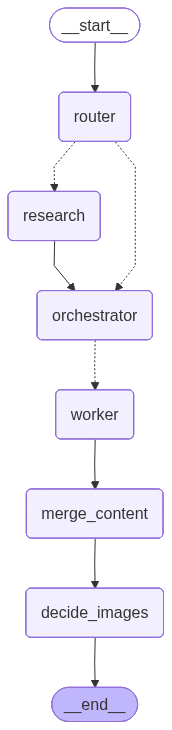

In [28]:
# -----------------------------
# 9) Build main graph (stop at worker)
# -----------------------------
g = StateGraph(State)

g.add_node("router", router_node)
g.add_node("research", research_node)
g.add_node("orchestrator", orchestrator_node)
g.add_node("worker", worker_node)
g.add_node("merge_content" , merge_content)
g.add_node("decide_images" , decide_images)
g.add_edge(START, "router")
g.add_conditional_edges(
    "router",
    route_next,
    {
        "research": "research",
        "orchestrator": "orchestrator"
    }
)

g.add_edge("research", "orchestrator")

g.add_conditional_edges("orchestrator", fanout, ["worker"])

# ✅ stop here
g.add_edge("worker", "merge_content")
g.add_edge("merge_content", "decide_images")
g.add_edge("decide_images", END)


app = g.compile()
app

In [29]:
response = app.invoke({'topic' : "Self Attention in Transformer Architecture"})

In [37]:
print(response["md_with_placeholders"])

# Self Attention in Transformer Architecture

Self Attention is a mechanism introduced in the Transformer architecture to address the limitations of Recurrent Neural Networks (RNNs) in handling long-range dependencies and parallelizing processing. RNNs process sequences step-by-step, which is slow and can lead to vanishing gradient problems. Self-attention allows every token in the sequence to attend to all other tokens, enabling the model to capture dependencies regardless of distance.

## What is Self-Attention?

Self-attention, also known as scaled dot-product attention, is a key component of Transformers. It enables each position in a sequence to interact with all other positions. The mechanism involves three sets of vectors derived from the input embeddings: Queries (Q), Keys (K), and Values (V). For each token, the model computes a Query vector, and compares it with all Key vectors to determine attention weights. These weights indicate how much each token should attend to others.